# 

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from torchmetrics import Accuracy

# Data Pre Processing

In [265]:
gender=pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
gender.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [266]:
train=pd.read_csv("/kaggle/input/titanic/train.csv")
test=pd.read_csv("/kaggle/input/titanic/test.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [267]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [268]:
train=train.drop(["Name","Ticket","Embarked"],axis='columns')
test=test.drop(["Name","Ticket","Embarked"],axis='columns')
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin
0,1,0,3,male,22.0,1,0,7.2500,NaN
1,2,1,1,female,38.0,1,0,71.2833,C85
2,3,1,3,female,26.0,0,0,7.9250,NaN
3,4,1,1,female,35.0,1,0,53.1000,C123
4,5,0,3,male,35.0,0,0,8.0500,NaN


In [269]:
train['Cabin'] = train['Cabin'].str[0].fillna('U')  # U for Unknown/NAN
test['Cabin'] = test['Cabin'].str[0].fillna('U')
y_train=train["Survived"]
x_train=train.drop("Survived",axis=1)
print(x_train.head(), y_train.head())

   PassengerId  Pclass     Sex   Age  SibSp  Parch     Fare Cabin
0            1       3    male  22.0      1      0   7.2500     U
1            2       1  female  38.0      1      0  71.2833     C
2            3       3  female  26.0      0      0   7.9250     U
3            4       1  female  35.0      1      0  53.1000     C
4            5       3    male  35.0      0      0   8.0500     U 0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64


In [270]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin
0,1,0,3,male,22.0,1,0,7.2500,U
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,U
3,4,1,1,female,35.0,1,0,53.1000,C
4,5,0,3,male,35.0,0,0,8.0500,U


In [271]:
# cabin vs survival
results=train.groupby("Cabin")["Survived"].value_counts().unstack(fill_value=0)
results.columns = ['not_survived', 'survived']
results = results.sort_values(by='survived', ascending=False)
print(results) 

       not_survived  survived
Cabin                        
U               481       206
B                12        35
C                24        35
D                 8        25
E                 8        24
F                 5         8
A                 8         7
G                 2         2
T                 1         0


In [272]:
# Male---> 1 , Female----> 0
x_train["Sex"]=np.where(x_train["Sex"]=="male",1,0)
x_train=x_train.drop("PassengerId",axis=1)

test["Sex"]=np.where(test["Sex"]=="male",1,0)
# test=x_train.drop("PassengerId",axis=1)
print(test.head())

   PassengerId  Pclass  Sex   Age  SibSp  Parch     Fare Cabin
0          892       3    1  34.5      0      0   7.8292     U
1          893       3    0  47.0      1      0   7.0000     U
2          894       2    1  62.0      0      0   9.6875     U
3          895       3    1  27.0      0      0   8.6625     U
4          896       3    0  22.0      1      1  12.2875     U


In [273]:
#pd.get_dummies() for OHE
cabin_OHE=pd.get_dummies(x_train["Cabin"],columns=["Cabin"]).astype(int)
x_train=x_train.drop(["Cabin"],axis=1)
x_train_final=pd.concat([x_train,cabin_OHE],axis=1)
#test 
cabin_OHE_test=pd.get_dummies(test["Cabin"],columns=["Cabin"]).astype(int)
test=test.drop(["Cabin"],axis=1)
test=pd.concat([test,cabin_OHE_test],axis=1)

In [274]:
x_train_final.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,A,B,C,D,E,F,G,T,U
0,3,1,22.0,1,0,7.2500,0,0,0,0,0,0,0,0,1
1,1,0,38.0,1,0,71.2833,0,0,1,0,0,0,0,0,0
2,3,0,26.0,0,0,7.9250,0,0,0,0,0,0,0,0,1
3,1,0,35.0,1,0,53.1000,0,0,1,0,0,0,0,0,0
4,3,1,35.0,0,0,8.0500,0,0,0,0,0,0,0,0,1


In [275]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,A,B,C,D,E,F,G,U
0,892,3,1,34.5,0,0,7.8292,0,0,0,0,0,0,0,1
1,893,3,0,47.0,1,0,7.0000,0,0,0,0,0,0,0,1
2,894,2,1,62.0,0,0,9.6875,0,0,0,0,0,0,0,1
3,895,3,1,27.0,0,0,8.6625,0,0,0,0,0,0,0,1
4,896,3,0,22.0,1,1,12.2875,0,0,0,0,0,0,0,1


In [276]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [277]:
print(x_train_final.isnull().sum())
x_train_final["Age"]=x_train_final["Age"].fillna(x_train_final["Age"].mean())
print(x_train_final.isnull().sum())

Pclass      0
Sex         0
Age       177
SibSp       0
Parch       0
Fare        0
A           0
B           0
C           0
D           0
E           0
F           0
G           0
T           0
U           0
dtype: int64
Pclass    0
Sex       0
Age       0
SibSp     0
Parch     0
Fare      0
A         0
B         0
C         0
D         0
E         0
F         0
G         0
T         0
U         0
dtype: int64


In [278]:
print(test.isnull().sum())

PassengerId     0
Pclass          0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
A               0
B               0
C               0
D               0
E               0
F               0
G               0
U               0
dtype: int64


In [279]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,A,B,C,D,E,F,G,U
0,892,3,1,34.5,0,0,7.8292,0,0,0,0,0,0,0,1
1,893,3,0,47.0,1,0,7.0000,0,0,0,0,0,0,0,1
2,894,2,1,62.0,0,0,9.6875,0,0,0,0,0,0,0,1
3,895,3,1,27.0,0,0,8.6625,0,0,0,0,0,0,0,1
4,896,3,0,22.0,1,1,12.2875,0,0,0,0,0,0,0,1


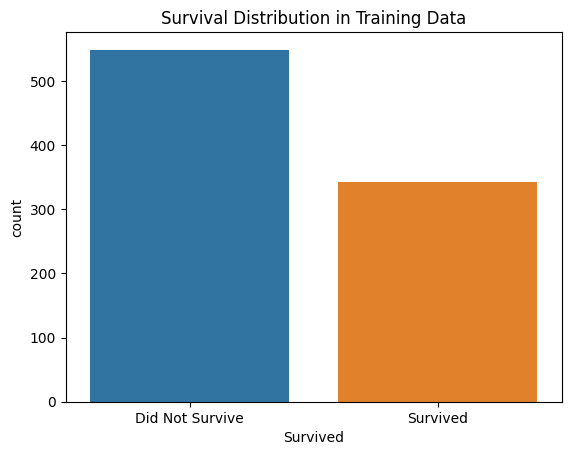

In [280]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=y_train)
plt.xticks([0,1], ['Did Not Survive', 'Survived'])
plt.title('Survival Distribution in Training Data')
plt.show()

# Model Development

In [281]:
class survival(nn.Module):
    def __init__(self):
        super(survival,self).__init__() # Even if i override parent class still i can use parent class methods.
        self.net=nn.Sequential(
            nn.Linear(15,50),
            nn.ReLU(),
            nn.Linear(50,75),
            nn.ReLU(),
            # nn.Linear(75,40),
            # nn.ReLU(),
            nn.Dropout(.6),
            nn.Linear(75,25),
            nn.ReLU(),
            nn.Linear(25,5),
            nn.ReLU(),
            nn.Linear(5,1),
            nn.Sigmoid()
        ) # Use of f(x)--> R-->G()---> R---> H()...makes it behave like a non linear regression

    def forward(self,x):
        return self.net(x)

model=survival()

In [282]:
# Data Preparation
from torch.utils.data import random_split

noise=1.1
x_train_final=torch.tensor(x_train_final.values,dtype=torch.float)
# x_train_final=F.normalize(x_train_final)
y_train=torch.tensor(y_train.values,dtype=torch.float).unsqueeze(1) # 32*1 instead of 32 # and float to handle logits for BCE()

# Tensor Dataset concats and process , DataLoader shuffles and bacthes!
training_data=TensorDataset(noise*x_train_final,y_train)

# Split sizes
val_ratio = 0.2  # 20% validation
val_size = int(len(training_data) * val_ratio)
train_size = len(training_data) - val_size

# Random split
training_data, val_data = random_split(training_data, [train_size, val_size])

train_loader=DataLoader(training_data,batch_size=32,shuffle=True)
val_loader=DataLoader(val_data,batch_size=32,shuffle=False)

In [283]:
print(len(x_train_final),len(y_train))
print(x_train_final.shape,y_train.shape)
print(len(train_loader),len(val_loader))
for xb, yb in train_loader:
    print(f"Batch train X shape: {xb.shape}")
    print(f"Batch train y shape: {yb.shape}")
    break  # just one batch


891 891
torch.Size([891, 15]) torch.Size([891, 1])
23 6
Batch train X shape: torch.Size([32, 15])
Batch train y shape: torch.Size([32, 1])


# Training Phase

In [ ]:
# Hyper parameters

Loss=nn.BCELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=.0001) # Auto adapts moment
train_acc=Accuracy(task="binary")
val_acc=Accuracy(task="binary")
epochs=1000
counter=0

# Training
for i in range(1,epochs+1):
    model.train()   # Dropout , batch norm ON
    counter+=1
    # Train
    for x,y in train_loader:
        optimizer.zero_grad()
        output=model(x)
        loss_itr=Loss(output,y)
        loss_itr.backward()
        optimizer.step()
        train_acc.update(output,y)
    train_accuracy=train_acc.compute()
    # Validation
    model.eval()   # Dropout , Batch norm OFF
    val_acc.reset()
    with torch.no_grad():
        for x ,y in val_loader:
            pred=model(x)
            val_acc.update(pred,y)
        val_accuracy=val_acc.compute()
    if counter%25==0:
        print(f"Epoch: {i}/{epochs},Loss: {loss_itr.item():.4f}, Train_Acc:{train_accuracy:.4f} , Val_Acc: {val_accuracy: .4f}")



In [285]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,A,B,C,D,E,F,G,U
0,892,3,1,34.5,0,0,7.8292,0,0,0,0,0,0,0,1
1,893,3,0,47.0,1,0,7.0000,0,0,0,0,0,0,0,1
2,894,2,1,62.0,0,0,9.6875,0,0,0,0,0,0,0,1
3,895,3,1,27.0,0,0,8.6625,0,0,0,0,0,0,0,1
4,896,3,0,22.0,1,1,12.2875,0,0,0,0,0,0,0,1


In [286]:
passenger_ids=test["PassengerId"]
test=test.drop("PassengerId", axis=1)
test.head()


,Pclass,Sex,Age,SibSp,Parch,Fare,A,B,C,D,E,F,G,U
0,3,1,34.5,0,0,7.8292,0,0,0,0,0,0,0,1
1,3,0,47.0,1,0,7.0000,0,0,0,0,0,0,0,1
2,2,1,62.0,0,0,9.6875,0,0,0,0,0,0,0,1
3,3,1,27.0,0,0,8.6625,0,0,0,0,0,0,0,1
4,3,0,22.0,1,1,12.2875,0,0,0,0,0,0,0,1


In [287]:
test.insert(loc=13, column='T', value=0)

In [288]:
test["Age"]=test["Age"].fillna(test["Age"].mean())
test["Fare"]=test["Fare"].fillna(test["Fare"].mean())
print(test.isnull().sum())

Pclass    0
Sex       0
Age       0
SibSp     0
Parch     0
Fare      0
A         0
B         0
C         0
D         0
E         0
F         0
G         0
T         0
U         0
dtype: int64


In [289]:
test_tensor=torch.tensor(test.values,dtype=torch.float)
print(test.head())

   Pclass  Sex   Age  SibSp  Parch     Fare  A  B  C  D  E  F  G  T  U
0       3    1  34.5      0      0   7.8292  0  0  0  0  0  0  0  0  1
1       3    0  47.0      1      0   7.0000  0  0  0  0  0  0  0  0  1
2       2    1  62.0      0      0   9.6875  0  0  0  0  0  0  0  0  1
3       3    1  27.0      0      0   8.6625  0  0  0  0  0  0  0  0  1
4       3    0  22.0      1      1  12.2875  0  0  0  0  0  0  0  0  1


In [290]:
model.eval()
with torch.no_grad():
    outputs=model(test_tensor)
    prediction_labels=outputs.squeeze()
    predictions= (prediction_labels>=.5).long()
    print(predictions)

tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,

In [291]:
submission=pd.DataFrame(
    {
        "PassengerId":passenger_ids,
        "Survived":predictions.numpy()
    }
)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [292]:
submission.to_csv("gender_submission_Titanic_Survival.csv",index=False)

In [293]:
submission.to_csv("gender_submission_Titanic_Survival.xlsx",index=False)

In [294]:
print("My first Successfully built Neural Network, Thank You !")

My first Successfully built Neural Network, Thank You !
